In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from utils.helpers import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
%load_ext autoreload
%autoreload 2

In [2]:
# Especifica las columnas que deseas cargar
columns_to_load = ['transaction_date', 'transaction_amount', 'transaction_type', 'fraction_flag', 'user_id']

# Lectura de los datos
data = pd.read_parquet(
    path='../../data/processed/data_processed.parquet',
    columns=columns_to_load
)

data.sample(5, random_state=777)

,transaction_date,transaction_amount,transaction_type,fraction_flag,user_id
312003,2021-01-04 21:29:44,5.94,DEBITO,FRACCIONADA,12ab5cc12c5a7f19d15ece999ab6da0f
3244910,2021-05-08 09:29:44,309.11,DEBITO,NO_FRACCIONADA,c115dfc7ac12889f187f61b52d1227e0
3234617,2021-02-04 11:12:48,8.32,DEBITO,NO_FRACCIONADA,c07ce0056e9c0d71d45dd1c336241405
158815,2021-03-01 17:51:29,17.83,DEBITO,NO_FRACCIONADA,098251533301d9bf4735a54da9cabccb
1024802,2021-06-29 14:40:10,356.67,DEBITO,NO_FRACCIONADA,3cff80c54fd326d7f98a58976879bb01


In [3]:
# Dimensiones del dataset
print(f'Número de muestras: {data.shape[0]}')
print(f'Predictores: {data.shape[1]}\n')
data.info()

Número de muestras: 4303384
Predictores: 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4303384 entries, 0 to 4303383
Data columns (total 5 columns):
 #   Column              Dtype         
---  ------              -----         
 0   transaction_date    datetime64[ns]
 1   transaction_amount  float64       
 2   transaction_type    object        
 3   fraction_flag       object        
 4   user_id             object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 164.2+ MB


In [4]:
# Función para capturar los tipos de variables
continuous, categoricals, discretes, temporaries = capture_variables(data=data.loc[:, data.columns != 'fraction_flag']) # type: ignore

		Tipos de variables
Hay 1 variables continuas
Hay 0 variables discretas
Hay 1 variables temporales
Hay 2 variables categóricas


In [5]:
# Resumen estadístico de variables continuas
data[continuous].describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_amount,"4,303,384.00",191.34,241.53,5.94,35.67,107.00,237.78,"3,210.01"


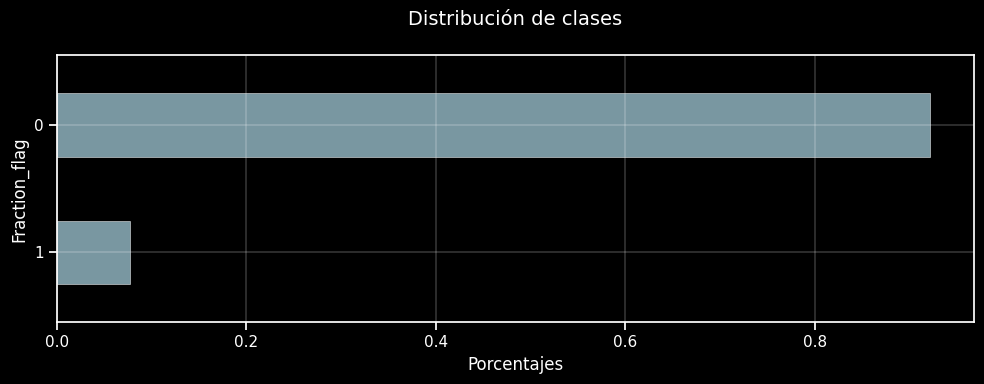

In [6]:
# Distribución de clases
class_distribution(
    data=data, 
    target='fraction_flag'
)

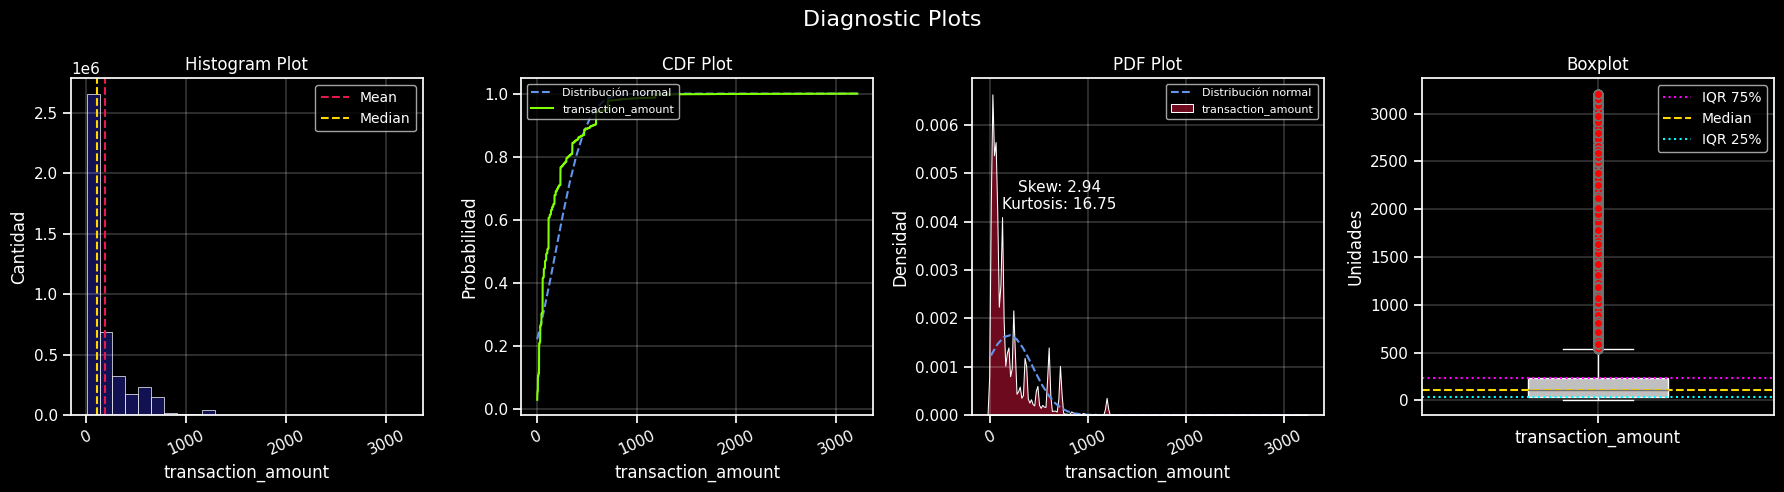

In [7]:
# Función para observar el comportamiento de variables continuas
diagnostic_plots(
    data=data.loc[:, data.columns != 'fraction_flag'],
    variables=continuous
)

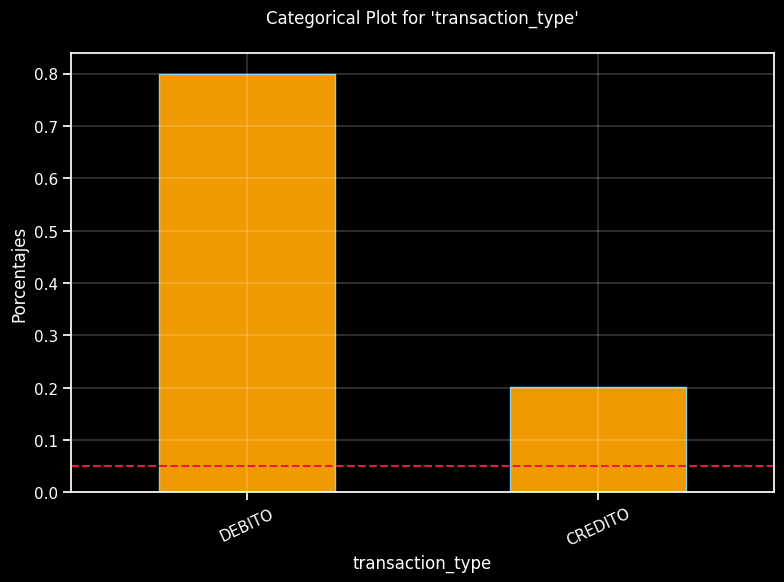

In [8]:
# Función para observar el comportamiento de variables categóricas
single_categorical_plot(
    data=data.loc[:, data.columns != 'fraction_flag'], 
    variable=categoricals[0]
)

---
### 2. Area de Negocios

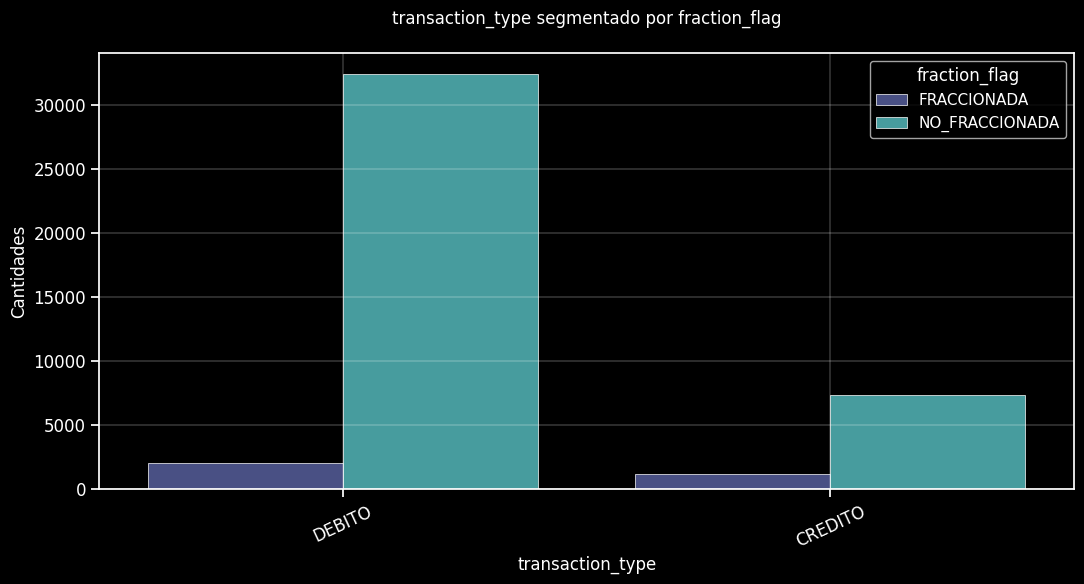

In [9]:
# Función para graficar las categóricas segmentadas por el target
categoricals_hue_target(
    data=data.sample(frac=0.01, random_state=777),
    variables=['transaction_type'],
    target='fraction_flag'
)

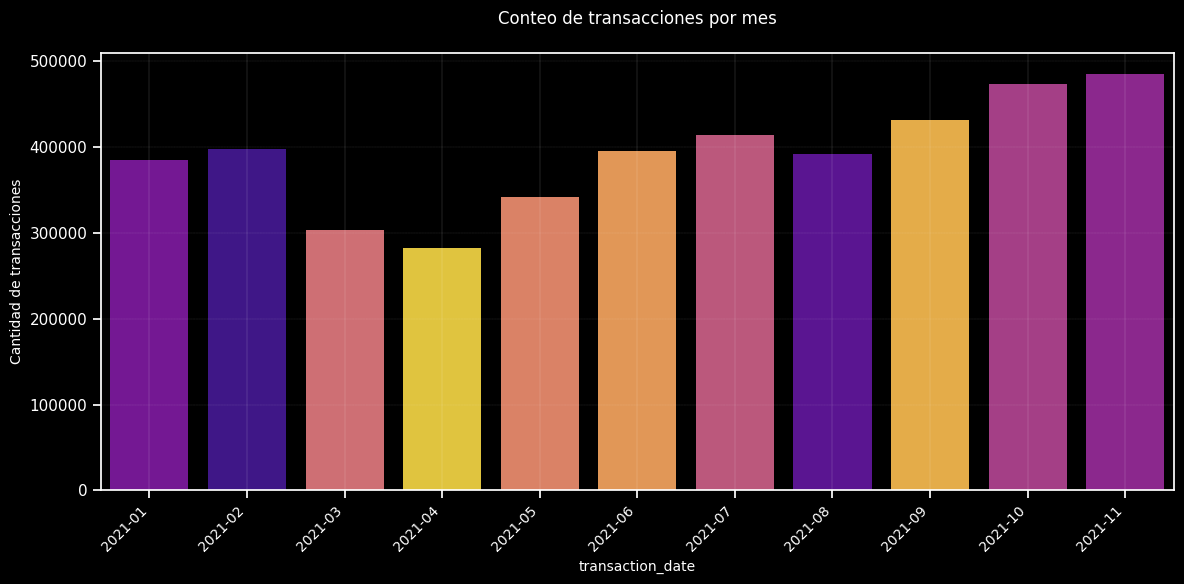

In [13]:
# Ordenar las fechas en orden cronológico
data['transaction_month'] = data['transaction_date'].dt.to_period('M')
sorted_months = data['transaction_month'].sort_values().unique()

# Crear un gráfico countplot para los meses ordenados
plt.figure(figsize=(12, 6))
sns.countplot(
    data=data,
    x='transaction_month',
    hue='transaction_month',
    palette='plasma',
    order=sorted_months,
    dodge=False
)

# Configurar etiquetas y título
plt.xlabel('transaction_date', fontsize=10)
plt.ylabel('Cantidad de transacciones', fontsize=10)
plt.title('Conteo de transacciones por mes\n', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.grid(color='white', linewidth=0.1)
plt.tight_layout()
plt.show()

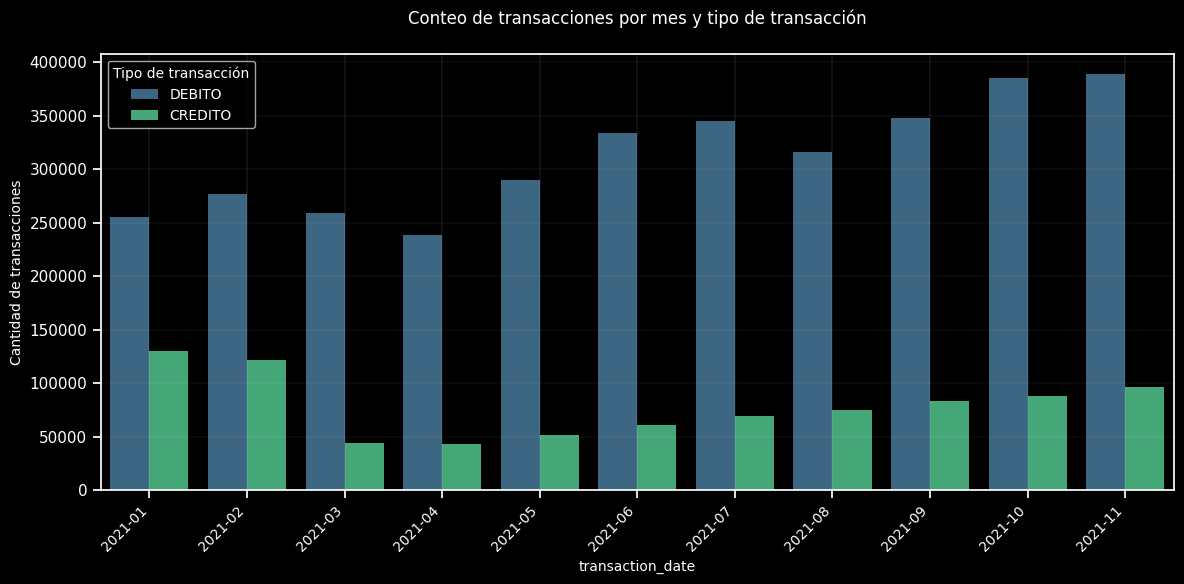

In [14]:
# Crear un gráfico countplot para los meses agrupado por tipo de transacción
plt.figure(figsize=(12, 6))
sns.countplot(
    data=data, 
    x='transaction_month', 
    hue='transaction_type',  # Agregar agrupación por tipo de transacción
    palette='viridis', 
    order=sorted_months
)

# Configurar etiquetas y título
plt.xlabel('transaction_date', fontsize=10)
plt.ylabel('Cantidad de transacciones', fontsize=10)
plt.title('Conteo de transacciones por mes y tipo de transacción\n', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Tipo de transacción', fontsize=10, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.grid(color='white', linewidth=0.1)
plt.show()

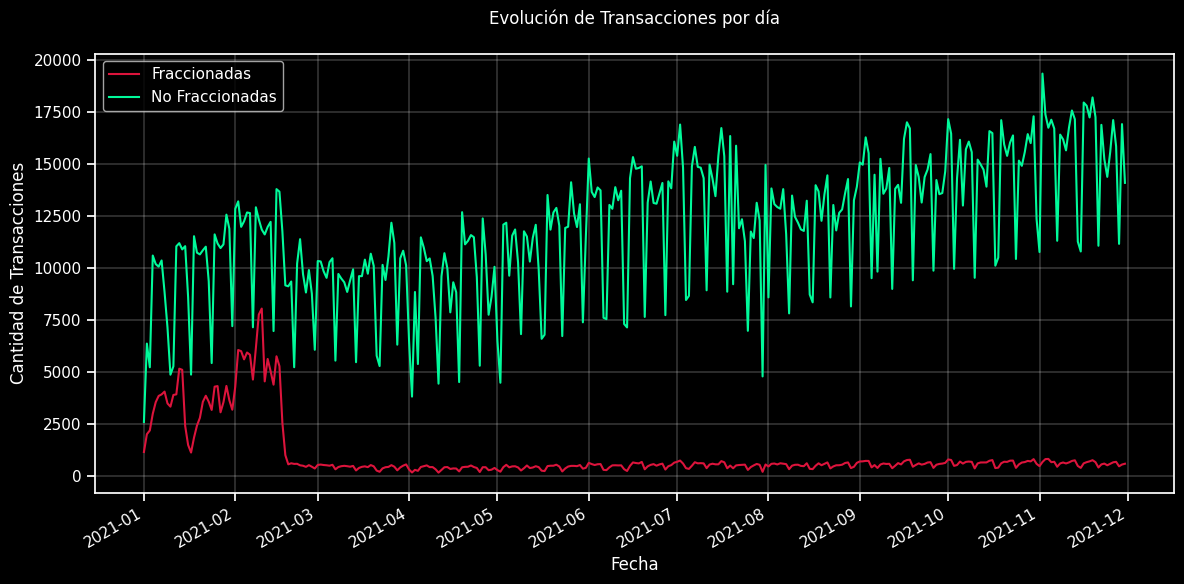

In [12]:
import matplotlib.dates as mdates

# Crear una columna de fecha truncada (YYYY-MM-DD) si no existe
data['date'] = data['transaction_date'].dt.date

# Contar transacciones fraccionadas por día
daily_frac = (
    data[data['fraction_flag'] == 'FRACCIONADA']
    .groupby('date')
    .size()
    .reset_index(name='count_fraccionada')
)

# Contar transacciones no fraccionadas por día
daily_no_frac = (
    data[data['fraction_flag'] == 'NO_FRACCIONADA']
    .groupby('date')
    .size()
    .reset_index(name='count_no_fraccionada')
)

# Juntar info si quieres ver ambas series en un mismo DataFrame
daily_merged = pd.merge(daily_frac, daily_no_frac, on='date', how='outer')
daily_merged.fillna(0, inplace=True)  # por si alguna fecha no tiene fraccionadas/no fraccionadas
daily_merged.sort_values('date', inplace=True)

# Configurar el gráfico
plt.figure(figsize=(12, 6))
plt.plot(daily_merged['date'], daily_merged['count_fraccionada'], label='Fraccionadas', color='crimson')
plt.plot(daily_merged['date'], daily_merged['count_no_fraccionada'], label='No Fraccionadas', color='mediumspringgreen')

# Configurar las etiquetas del eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Mostrar etiquetas por mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato Año-Mes
plt.gcf().autofmt_xdate()  # Rotar etiquetas para mejorar la legibilidad

# Añadir detalles al gráfico
plt.title('Evolución de transacciones por día\n')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de transacciones')
plt.legend()
plt.grid(color='white', linewidth=0.25)
plt.tight_layout()
plt.show()